In [16]:
## output bikeshare density for what area could support
## output bikeability based on strava data to decide if area is a good idea
## Assumes that bike shares are optimally placed and near optimal capacity
## use regularization in the training of the ML model

import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Workaround to fix chrome issue where folium won't plot maps with a large number of layers
# See comment by dstein64 at: https://github.com/python-visualization/folium/issues/812

import base64
def _repr_html_(self, **kwargs):
    html = base64.b64encode(self.render(**kwargs).encode('utf8')).decode('utf8')
    onload = (
        'this.contentDocument.open();'
        'this.contentDocument.write(atob(this.getAttribute(\'data-html\')));'
        'this.contentDocument.close();'
    )
    if self.height is None:
        iframe = (
            '<div style="width:{width};">'
            '<div style="position:relative;width:100%;height:0;padding-bottom:{ratio};">'
            '<iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;'
            'border:none !important;" '
            'data-html={html} onload="{onload}" '
            'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
            '</iframe>'
            '</div></div>').format
        iframe = iframe(html=html, onload=onload, width=self.width, ratio=self.ratio)
    else:
        iframe = ('<iframe src="about:blank" width="{width}" height="{height}"'
                  'style="border:none !important;" '
                  'data-html={html} onload="{onload}" '
                  '"allowfullscreen" "webkitallowfullscreen" "mozallowfullscreen">'
                  '</iframe>').format
        iframe = iframe(html=html, onload=onload, width=self.width, height=self.height)
    return iframe

folium.branca.element.Figure._repr_html_ = _repr_html_


In [4]:
folder_name = 'OSM_geo_data/'
city_names = ['austin','berkeley','boston','chicago','denver','glasgow','los_angeles',
              'minneapolis','montreal','new_york','san_francisco','salt_lake_city']



# filename_grid = folder_name + city_name + '_grid.geojson'
# filename_amenities = folder_name + city_name + '_amenities.geojson'
# filename_bike_rentals = folder_name + city_name + '_bike_rentals.geojson'

# Initialize dataframe
df = pd.DataFrame()
city_grid = pd.DataFrame()

for name in city_names:
    filename_cleaned_df = folder_name + name + '_feature_target_table.geojson'
    filename_grid = folder_name + name + '_grid.geojson'
    if df.empty:
        df = gpd.read_file(filename_cleaned_df)
        city_grid = gpd.read_file(filename_grid)
    else:
        df = df.append(gpd.read_file(filename_cleaned_df), ignore_index=True)





In [5]:
# Define feature and target labels
features = ['pharmacy_density', 'recycling_density', 'place_of_worship_density', 'post_box_density',
            'library_density', 'post_office_density', 'parking_density', 'fuel_density', 'bank_density',
            'pub_density', 'telephone_density', 'toilets_density', 'taxi_density', 'bicycle_parking_density',
            'motorcycle_parking_density', 'fast_food_density', 'bar_density', 'life_boats_density',
            'restaurant_density', 'arts_centre_density', 'music_venue_density', 'nightclub_density',
            'cafe_density', 'atm_density', 'community_centre_density', 'jobcentre_density', 'doctors_density',
            'cinema_density', 'grave_yard_density', 'police_density', 'bus_station_density', 'theatre_density',
            'bureau_de_change_density', 'hospital_density', 'bench_density', 'school_density', 'courthouse_density',
            'ice_cream_density', 'fountain_density', 'left_luggage_density', 'drinking_water_density',
            'casino_density', 'car_rental_density', 'car_wash_density', 'ferry_terminal_density', 'dentist_density',
            'townhall_density', 'shelter_density', 'parking_entrance_density', 'conference_centre_density',
            'marketplace_density', 'vending_machine_density', 'waste_basket_density', 'clock_density',
            'studio_density', 'veterinary_density', 'gallery_density', 'gambling_density', 'kindergarten_density',
            'social_facility_density', 'charging_station_density', 'car_sharing_density', 'clinic_density',
            'water_density', 'compressed_air_density', 'public_building_density', 'social_centre_density',
            'childcare_density', 'grit_bin_density', 'bicycle_repair_station_density', 'events_venue_density',
            'embassy_density', 'college_density', 'circus_school_density', 'parcel_lockers_density',
            'money_transfer_density', 'photo_booth_density', 'luggage_locker_density', 'university_density',
            'venue_density', 'swimming_pool_density', 'fire_station_density', 'post_depot_density',
            'crematorium_density', 'sport_density', 'nursing_home_density', 'biergarten_density', 'garden_density',
            'prison_density', 'club_density', 'parking_space_density', 'trailer_park_density', 'archive_density',
            'monastery_density']
target = ['bike_rental_density']

663 5530 0.11989150090415913
Linear regression is not the best option given that the target is highly skewed towards 0


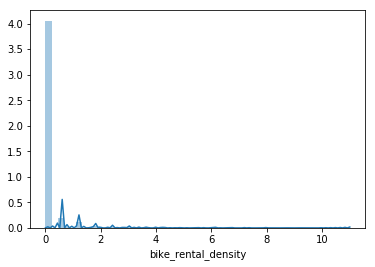

In [19]:
# Split data into train and test
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pos_target = len(y[y.bike_rental_density != 0])
neg_target = len(y[y.bike_rental_density == 0])
print(pos_target,neg_target,pos_target/neg_target)

sns.distplot(y.bike_rental_density);
print('Linear regression is not the best option given that the target is highly skewed towards 0')

In [20]:
## Linear model
LM_model = LinearRegression()
LM_model.fit(X_train,y_train)
LM_y_pred = LM_model.predict(X_test)

## Lasso
lasso_rmse = []
ridge_rmse = []
EN_rmse = []
alpha_ref = np.linspace(0.001,1,101)

for ind, alpha in enumerate(alpha_ref):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    
    ridge_model = Ridge(alpha = alpha)
    ridge_model.fit(X_train,y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    EN_model = ElasticNet(alpha = alpha)
    EN_model.fit(X_train,y_train)
    EN_y_pred = EN_model.predict(X_test)
    EN_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))


## Random Forest
# RF_model = RandomForestRegressor(random_state = 2,max_depth = 9,max_leaf_nodes = 67)
RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)
RF_y_pred = RF_model.predict(X_test)

# remove negative predictions
# y_pred[y_pred <0] = 0


/Users/peter/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [21]:
## Linear regression isn't the best option given that the target is highly skewed towards 0

print('Multivariate linear regression mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,LM_y_pred))
print('Lasso mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(lasso_rmse),alpha_ref[np.argmin(lasso_rmse)]))
print('Ridge mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(ridge_rmse),alpha_ref[np.argmin(ridge_rmse)]))
print('Elastic Net mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(EN_rmse),alpha_ref[np.argmin(EN_rmse)]))

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_y_pred))






Multivariate linear regression mean absolute error (MAE): 0.200
Lasso mean absolute error (MAE): 0.182 and alpha = 0.041
Ridge mean absolute error (MAE): 0.182 and alpha = 0.041
Elastic Net mean absolute error (MAE): 0.182 and alpha = 0.041
Random forest mean absolute error (MAE): 0.150


In [9]:
comparison = y_test.copy()
comparison['LM_y_pred'] = LM_y_pred
comparison['RF_y_pred'] = RF_y_pred
comparison['Lasso_y_pred'] = lasso_y_pred
comparison.head()

# diff = comparison.y_pred - comparison.bike_rental_density
# comparison['difference'] = diff
# comparison['bike_share_score'] =  y_pred / max(y_pred)
# # y_pred
# comparison

# # get grid index of positive bike share locations
# bike_share_pos_ind = list(comparison.index)



,bike_rental_density,LM_y_pred,RF_y_pred,Lasso_y_pred
3151,0.0,0.378685,0.229760,0.459461
3118,0.0,0.027067,0.000000,0.161091
2124,0.0,0.136567,0.101934,0.112893
3506,0.0,0.124785,0.000000,0.088133
3632,0.0,0.019680,0.057108,0.088133


In [ ]:
## Start validation on unseen city, 
place = 'Portland, Oregon, USA'

# city_grid = gpd.read_file(filename_grid)
# all_amenities = gpd.read_file(filename_amenities)
# bike_rentals = gpd.read_file(filename_bike_rentals)

# Generate city grid for interrogation
city = ox.gdf_from_place(place)


In [10]:
m = folium.Map([city.geometry.centroid.y, city.geometry.centroid.x],
               zoom_start=11,
               tiles="CartoDb dark_matter")

style_city = {'color':'#ebc923 ', 'fillColor': '#ebc923 ', 'weight':'1', 'fillOpacity' : 0.1}
folium.GeoJson(city, style_function=lambda x: style_city).add_to(m)

# plot grid points
# locs = zip(city_grid['geometry'].centroid.y, city_grid['geometry'].centroid.x)
# for location in locs:
#     folium.CircleMarker(location=location, 
#         color = "white",   radius=1).add_to(m)

# plot predictions of bike demand
style_region = {'color':'#1FFD09 ', 'fillColor': '#1FFD09 ', 'weight':'1', 'fillOpacity' : 0.1}
# for ind in bike_share_pos_ind:
for index, row in comparison.iterrows():
    folium.Choropleth(city_grid.geometry[city_grid.index == ind], fill_color = '#1FFD09',
                      fill_opacity = comparison.bike_share_score.loc[ind] ).add_to(m)
    
# plot bikable streets
# m = folium.Map(latlon,
#                zoom_start=15,
#                tiles="CartoDb dark_matter")
# folium.GeoJson(streets, style_function=lambda x: style).add_to(m)

# add cafes
# locs = zip(all_amenities.geometry.y, all_amenities.geometry.x)
# for location in locs:
#     folium.CircleMarker(location=location, 
#         color = "red",   radius=1).add_to(m)

# add bike rentals
# locs = zip(bike_rentals.geometry.y, bike_rentals.geometry.x)
# for location in locs:
#     folium.CircleMarker(location=location, 
#         color = "yellow",   radius=2, fill=True).add_to(m)

# m.save("chicago_bike_demand.html")
m

AttributeError: 'DataFrame' object has no attribute 'bike_share_score'

In [ ]:
search_place = 'USA'
new_bike_rentals = ox.pois_from_place(search_place, amenities=['bicycle_rental'])
len(new_bike_rentals)